# Hyperspectral - the other scans

In [2]:
import spectral.io.envi as envi
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

from sklearn.decomposition import PCA
from spectral import principal_components, imshow
from ipywidgets import interact

scans_dir = "C:\\Users\\ext-lugo\\Hyperspectral\\Radiance_home"
os.environ["SPECTRAL_DATA"] = scans_dir

In the other hyperspectral notebooks (no that the notebooks themselves are hyperspectral), the analysed scans have been the regular ones. However, there is another set of hyperspectral scans, taken under different conditions. It could be interesting to analyze these, and also apply the hyperspectral conversions studied in the Hyperspectral variations notebook.

## Simple preliminary analysis (yes, this time it will be simple)

Prior to doing a proper analysis of the poles, it is necessary to remove outlier readings from the poles. In the previous analysis, readings greater than 0.025 were considered outliers. However, a quick plot of the values of these poles shows that this threshold is not valid here. Therefore, a proper outlier removal algorithm will be used, based on the deviation with respect to the median.

In [3]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

def get_pole(pole_id, rotation_idx, draw=False):
    paths = os.listdir(os.path.join(scans_dir, str(pole_id)))
    paths = [path for path in paths if "float32.hdr" in path]
    paths.sort()
    ro_img = envi.open(os.path.join(str(pole_id), paths[rotation_idx])).load()
    wls = np.asarray(ro_img.metadata['wavelength'], float)
    
    img = ro_img
    if draw:
        plt.imshow(img[...,-1], cmap='gray')
    else:
        return img, wls
    
def visualize_no_outliers():
    fig, axes = plt.subplots(5, 4, figsize=(20,20))
    pole_ids = [0, 30, 41, 6, 5]
    rotation_idxs = [0, 1, 2, 3]
    
    for pole_idx, pole_id in enumerate(pole_ids):
        for rotation_idx in rotation_idxs:
            pole, _ = get_pole(pole_id, rotation_idx)
            pole = pole.flatten()
            pole = np.where(~is_outlier(pole, thresh=10), pole, 0)
            axes[pole_idx,rotation_idx].hist(pole, bins=100, log=True)
            del pole
            
    plt.savefig('../Figures/hyperspectral_histograms_home.png')
   

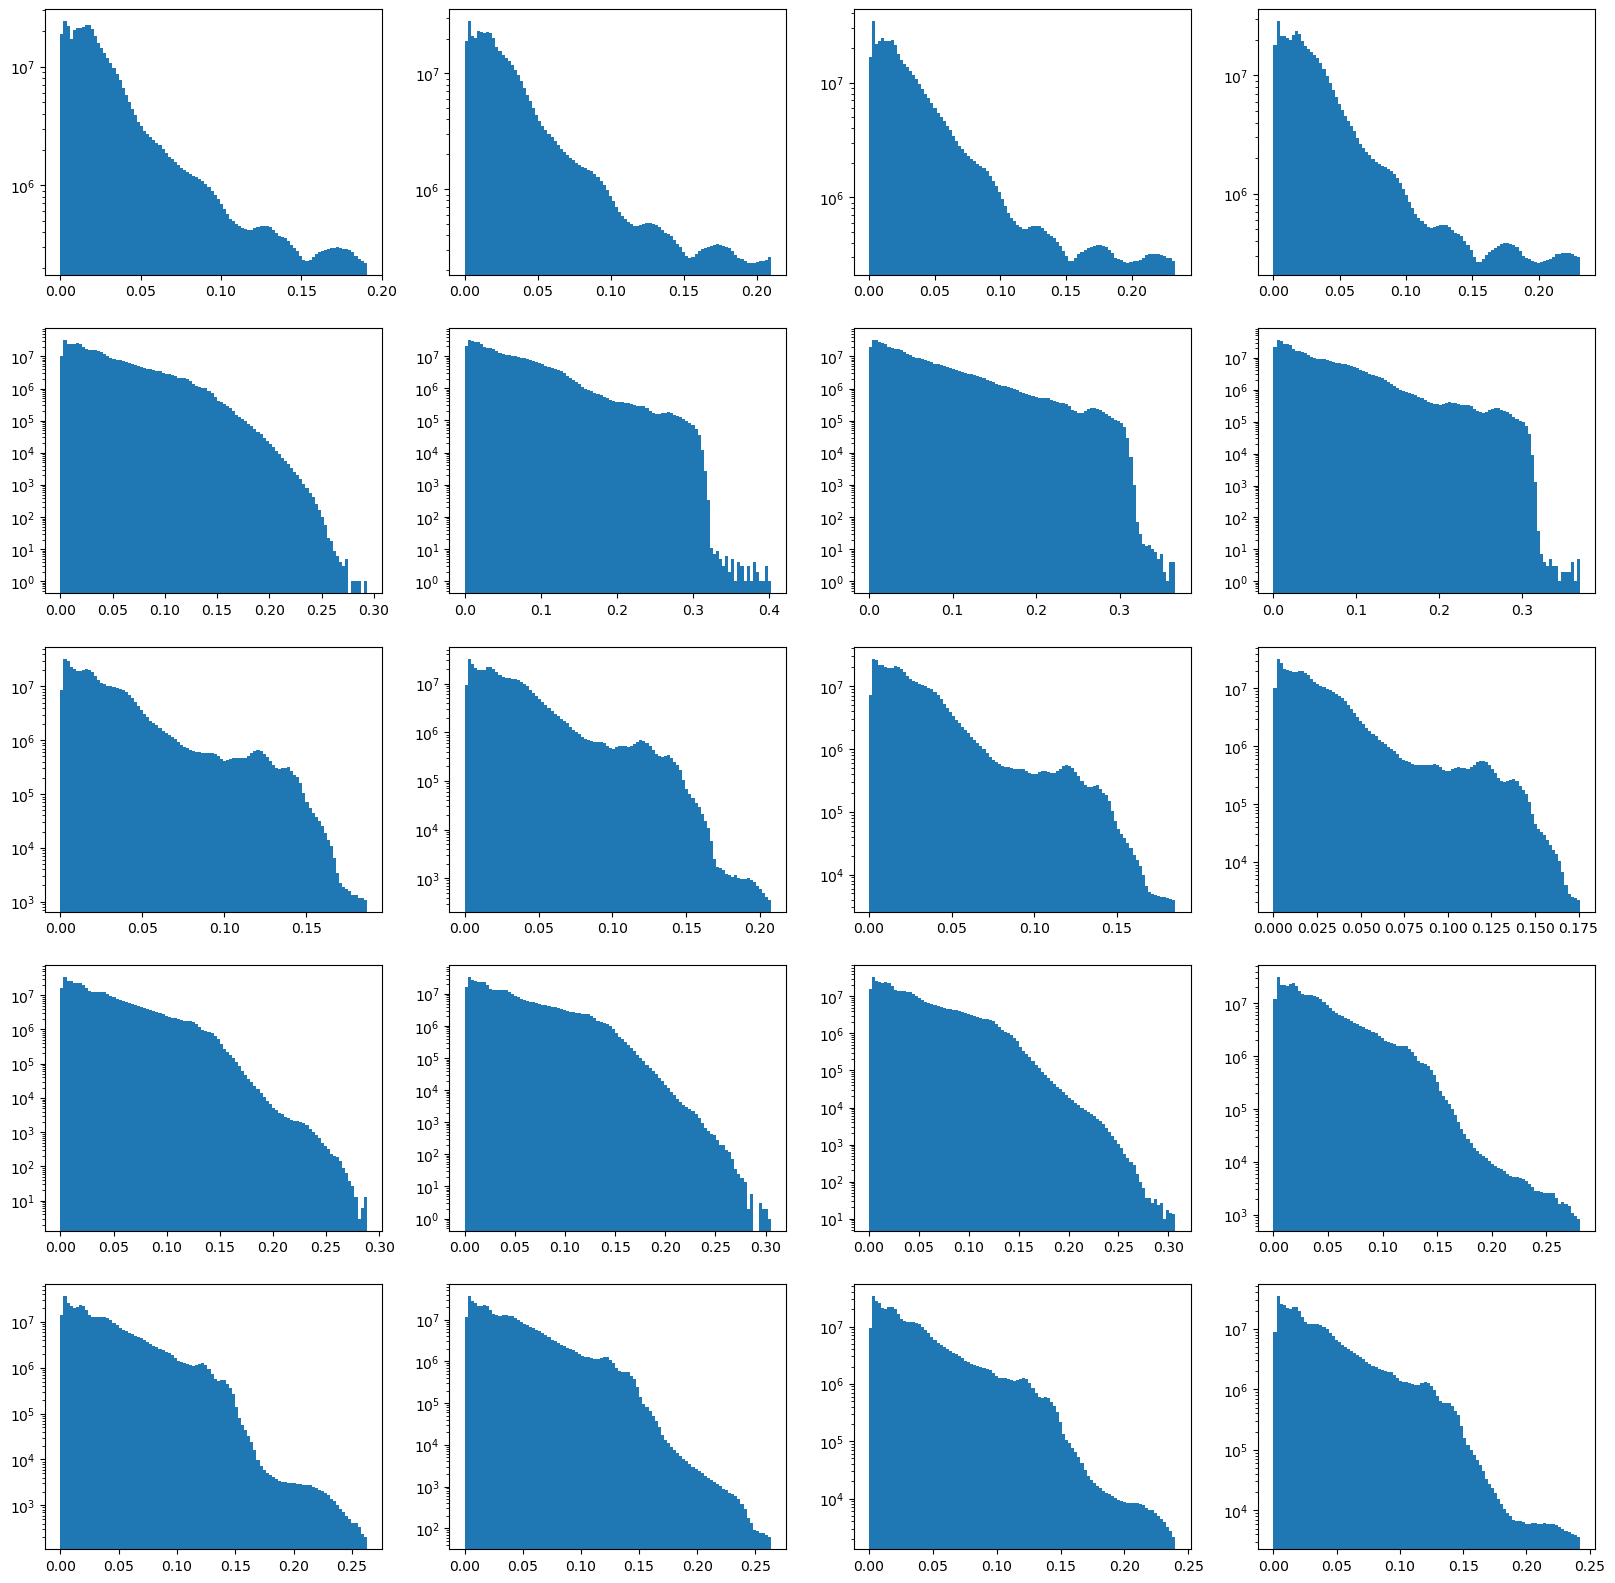

In [33]:
visualize_no_outliers()

As it can be seen on these figures, a threshold of 10 for the statistical test seems OK for removing most outliers without altering the original scans in a significant way. Once again, this step is just performed for visualization purposes. 

In [7]:
def show_pole(pole_id, rotation_idx, remove_outliers):
    paths = os.listdir(os.path.join(scans_dir, pole_id))
    paths = [path for path in paths if "float32.hdr" in path]
    paths.sort()
    print(f'Loading {paths[rotation_idx]}')
    img = envi.open(os.path.join(pole_id, paths[rotation_idx])).load()
    wls = np.asarray(img.metadata['wavelength'], float)
    
    if remove_outliers:
        orig_shape = img.shape
        img = img.flatten()
        img = np.where(~is_outlier(img, thresh=10), img, 0)
        img = np.reshape(img, orig_shape)
    
    def browse_images(img):
        bands = img.shape[-1]
        def view_images(i=99):
            plt.imshow(img[:,:,i], cmap='gray', interpolation='nearest')
            plt.title(f'{wls[i]} nm')
            plt.show()
        interact(view_images, i=(0, bands - 1))

    browse_images(img)

show_pole('5', 4, False)

Loading stolpe_1_Mjolnir_V-1240_SN5030_19499us_2022-04-28T121900_raw_rad_keystone_smile_spectralbinningx4_float32.hdr


interactive(children=(IntSlider(value=99, description='i', max=99), Output()), _dom_classes=('widget-interact'…

Judging by these figures, it looks like the pole is always on X-coordinates 300-900 and Y-coordinates 300-3300. Therefore, in order to obtain the spectra for this pole, it should be possible to do so by cropping this part of the scans, but a previous visualization can help confirm this is a good crop.

In [50]:
def view_hyperspectral_transformed(transform_func, description):
    fig, axes = plt.subplots(5, 5, figsize=(20,16))
    pole_ids = [0,30,41,6,5]
    pole_status = ['31/37', '17/24', '15/24', '12/24', '11/24']
    specific_status = ['New', 'Rotten', 'Cracks', 'Cracks', 'Rotten']

    for pole_idx, pole_id in enumerate(pole_ids):
        paths = os.listdir(os.path.join(scans_dir, str(pole_id)))
        paths = [path for path in paths if "float32.hdr" in path]
        paths.sort()
        for scan_idx in range(len(paths)):
            img = envi.open(os.path.join(str(pole_id), paths[scan_idx])).load()
            img = transform_func(img)
            axes[pole_idx, scan_idx].imshow(img, cmap='gray')

    fig.suptitle(description)

    [axes[0,i].set_title(f'Image #{i}') for i in range(5)]

    [axes[i,0].set_ylabel(f'Pole {pole}\nStatus: {pole_status[i]}\nCause: {specific_status[i]}', labelpad=60, fontdict={'rotation':0}) for i, pole in enumerate(pole_ids)]
    
    
def crop_hyperspectral_no_outliers(img):
    img = img [300:3100, 300:900, :]
    orig_shape = img.shape
    img = img.flatten()
    img = np.where(~is_outlier(img, thresh=10), img, 0)
    img = np.reshape(img, orig_shape)
    return img[...,-1]

def crop_hyperspectral(img):
    img = img [300:3100, 300:900, :]
    return img

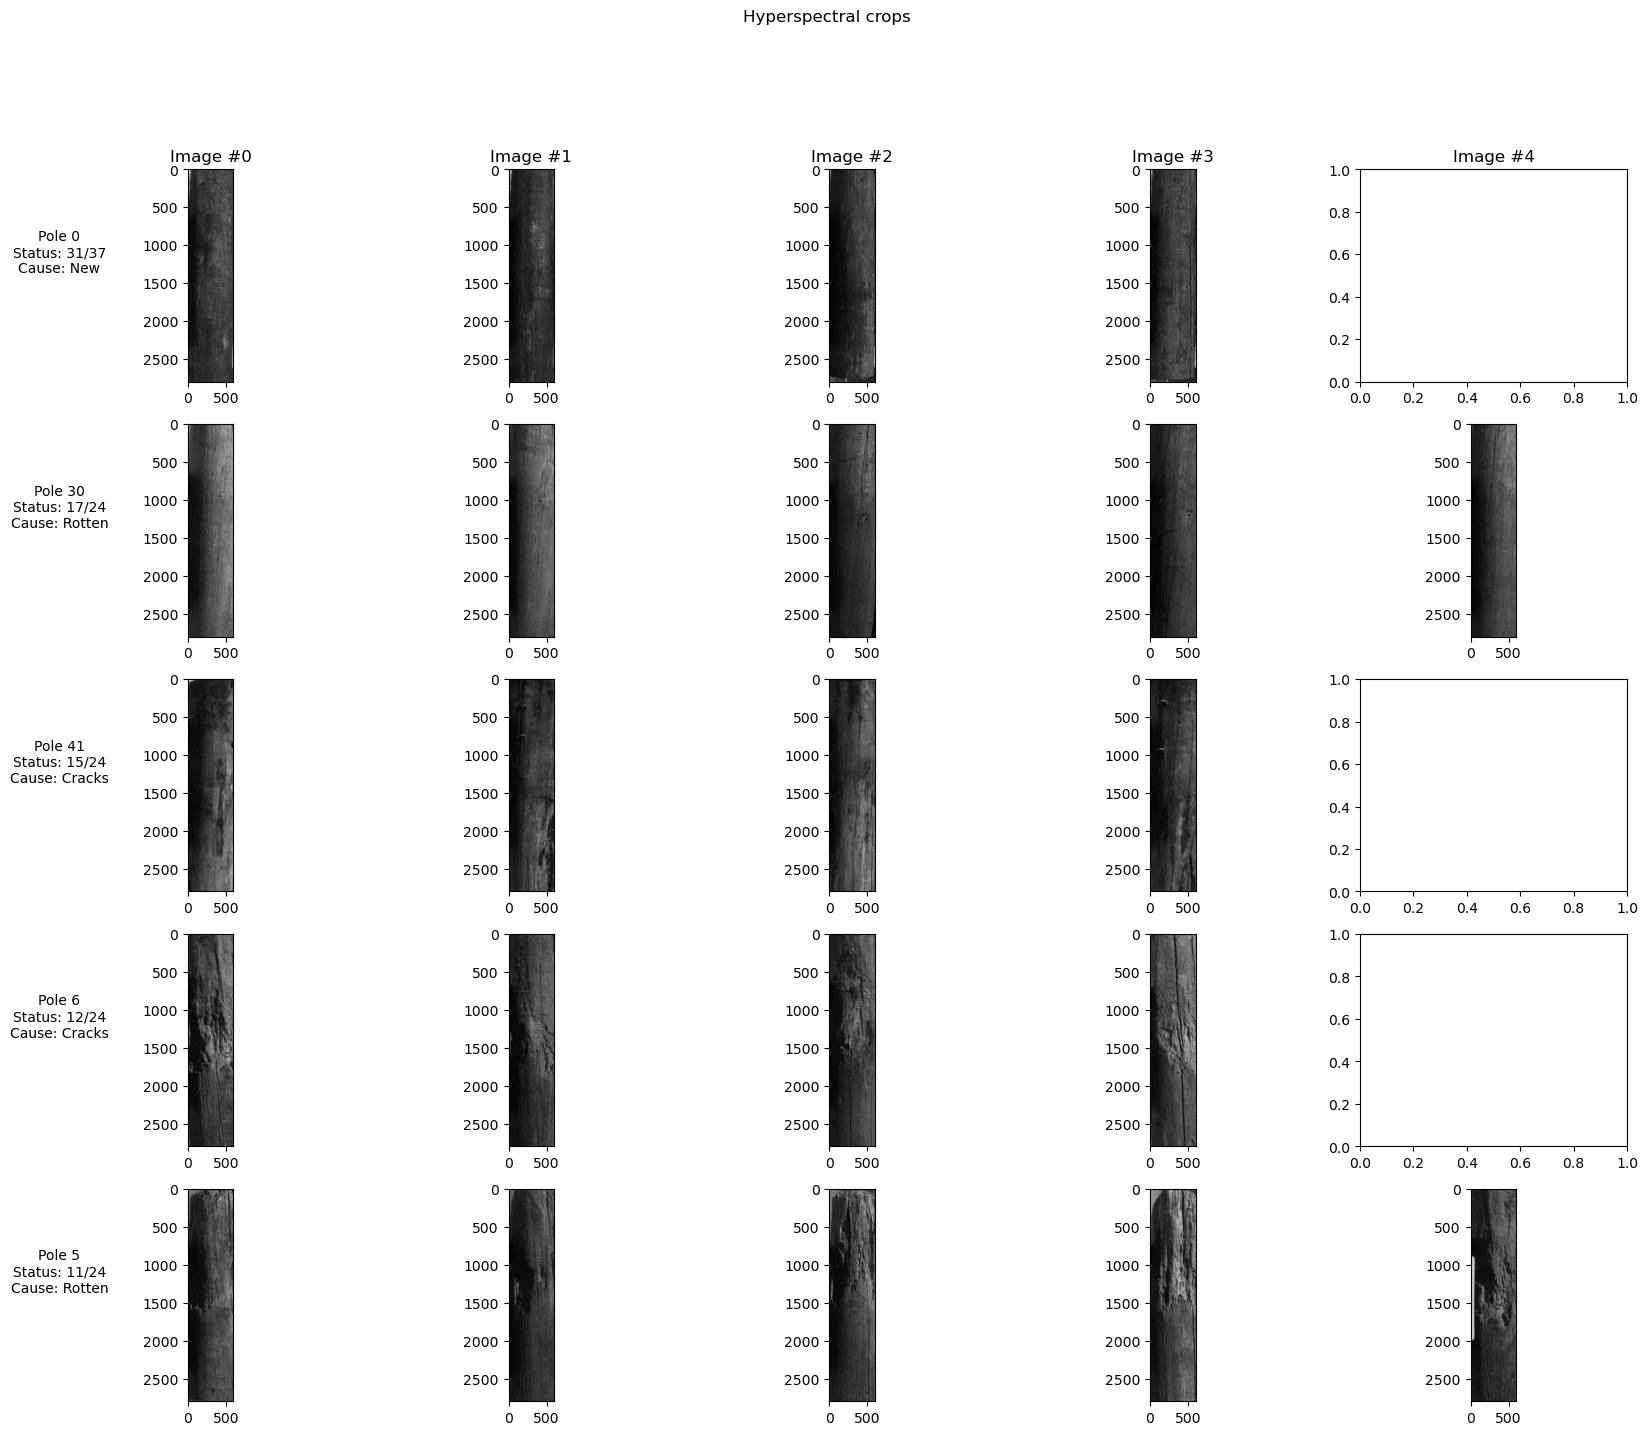

In [20]:
view_hyperspectral_transformed(crop_hyperspectral_no_outliers, 'Hyperspectral crops')

## Spectra analysis

With these crops, it should now be possible to perform a similar analysis to that of the other notebooks

In [57]:
def get_white_panel():
    path = os.path.join('5', 'stolpe_1_Mjolnir_V-1240_SN5030_19499us_2022-04-28T121900_raw_rad_keystone_smile_spectralbinningx4_float32.hdr')
    img = envi.open(path)
    return img[1200:2250,0:250,:]

In order to have results which can be compared with the ones of the previous scans, it would be good to compute these by dividing the average spectrum by the white panel spectrum. However, a visual examination of this spectrum shows that, approximately from bands 18 to 57, it has anomalously high values. Therefore, it could be better to perform the comparison by using radiance instead of reflectance.

In [66]:
def plot_average_spectra_per_pole_and_rotation(white_panel, reflectance=True):
    fig, axes = plt.subplots(5, 5, figsize=(20,16))
    pole_ids = [0,30,41,6,5]
    pole_status = ['31/37', '17/24', '15/24', '12/24', '11/24']
    specific_status = ['New', 'Rotten', 'Cracks', 'Cracks', 'Rotten']

    for pole_idx, pole_id in enumerate(pole_ids):
        paths = os.listdir(os.path.join(scans_dir, str(pole_id)))
        paths = [path for path in paths if "float32.hdr" in path]
        paths.sort()
        for scan_idx in range(len(paths)):
            img = envi.open(os.path.join(str(pole_id), paths[scan_idx])).load()
            wls = np.asarray(img.metadata['wavelength'], float)
            img = crop_hyperspectral(img)
            spectrum = np.average(img, axis=(0,1))
            white_spectrum = np.average(white_panel, axis=(0,1))
            
            if reflectance:
                spectrum = spectrum / white_spectrum
                                
            axes[pole_idx, scan_idx].plot(range(len(spectrum)), spectrum)
            axes[pole_idx, scan_idx].set_ylim((-0.1, 1.1))
            axes[pole_idx, scan_idx].set_xticks([0,50,99],[f'{wls[idx]:.0f}nm' for idx in [0,50,99]])

    fig.suptitle('Home poles spectra')

    [axes[0,i].set_title(f'Image #{i}') for i in range(5)]

    [axes[i,0].set_ylabel(f'Pole {pole}\nStatus: {pole_status[i]}\nCause: {specific_status[i]}', labelpad=60, fontdict={'rotation':0}) for i, pole in enumerate(pole_ids)]
    
    plt.savefig(f'home hyperspectral_results_per_pole_and_rotation_{"ref" if reflectance else "noref"}.png')

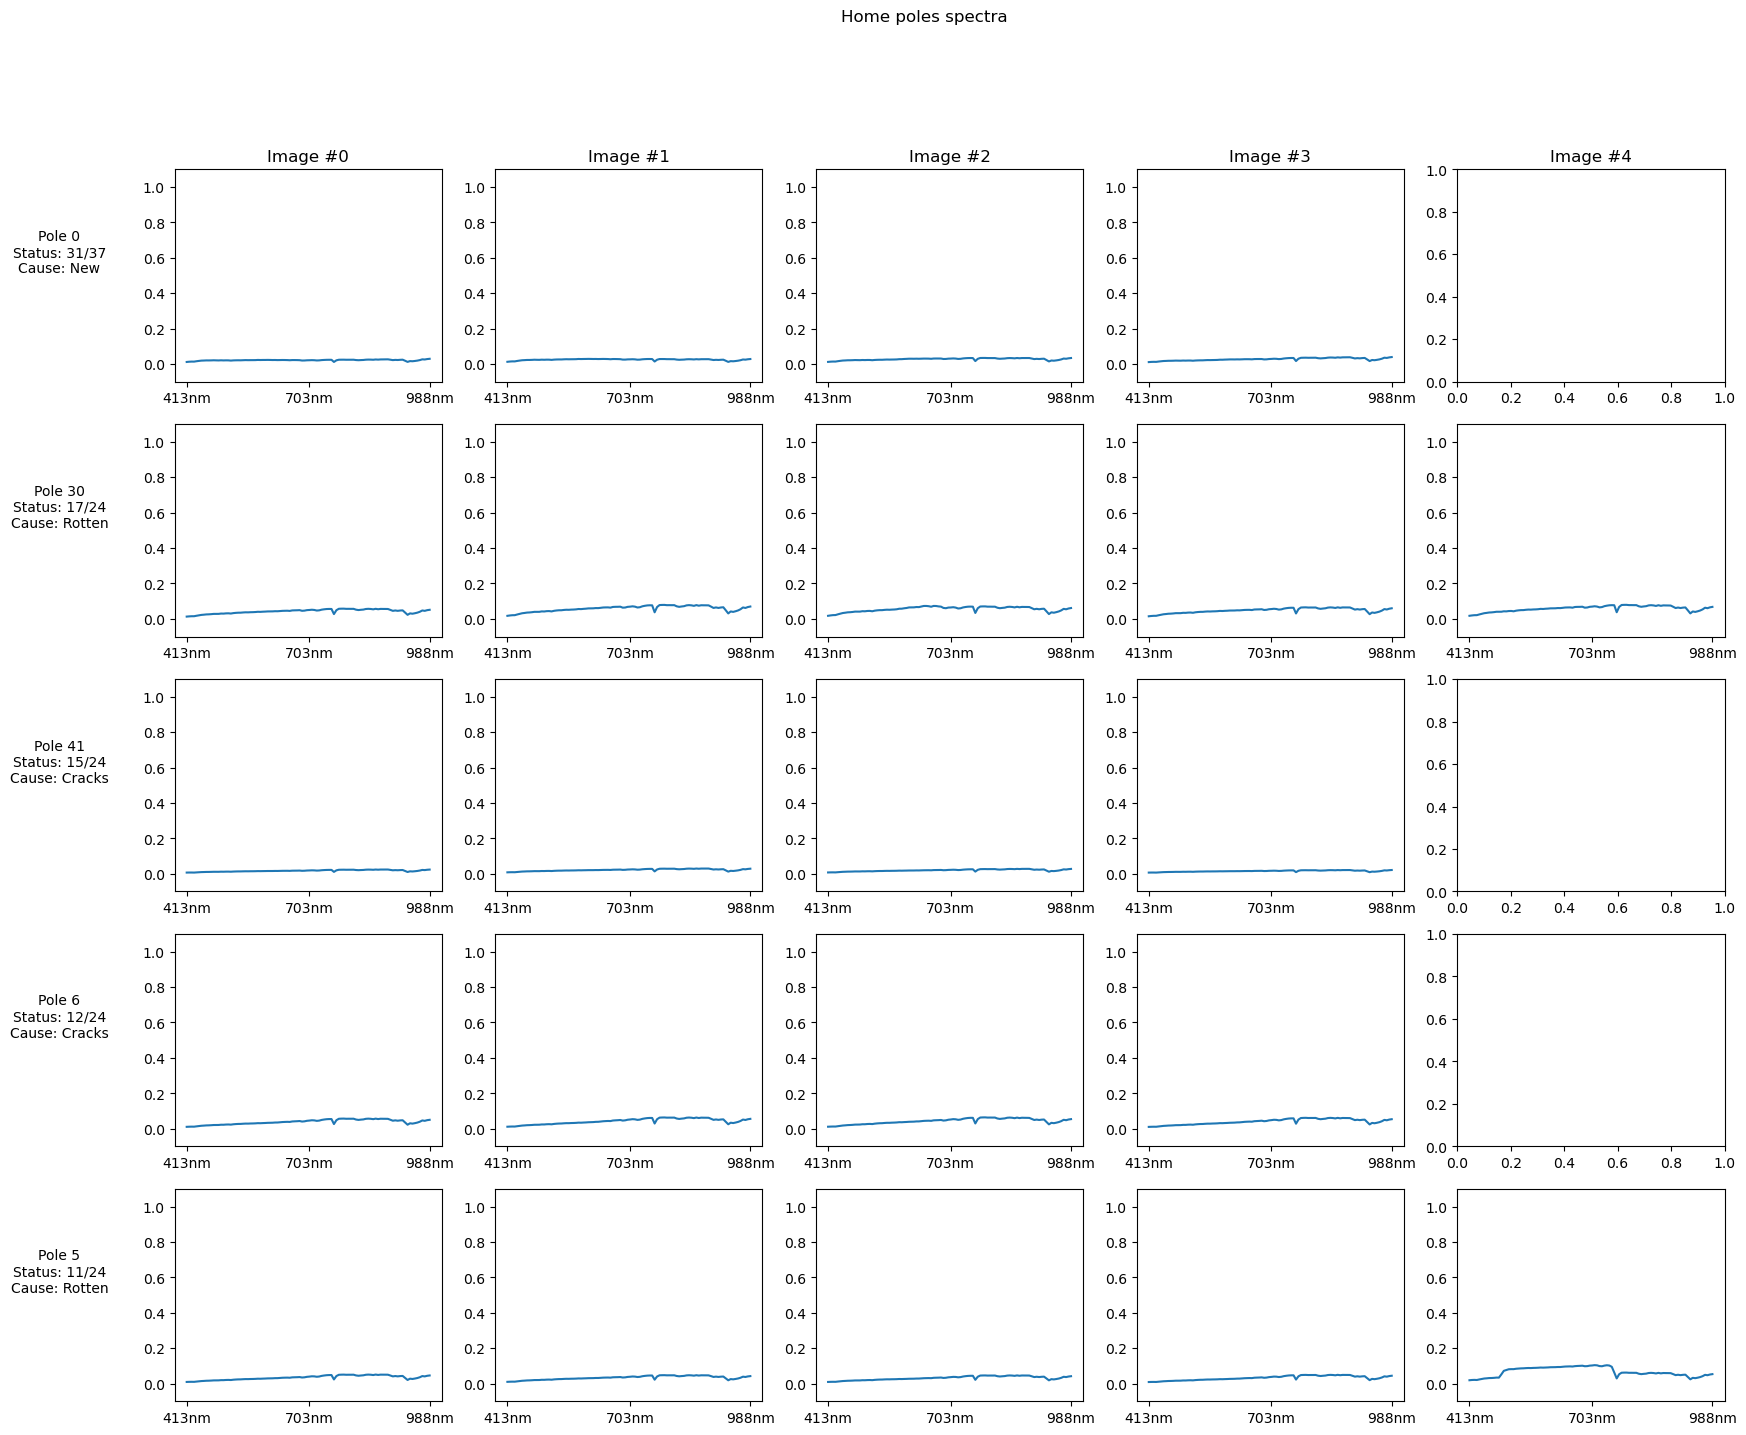

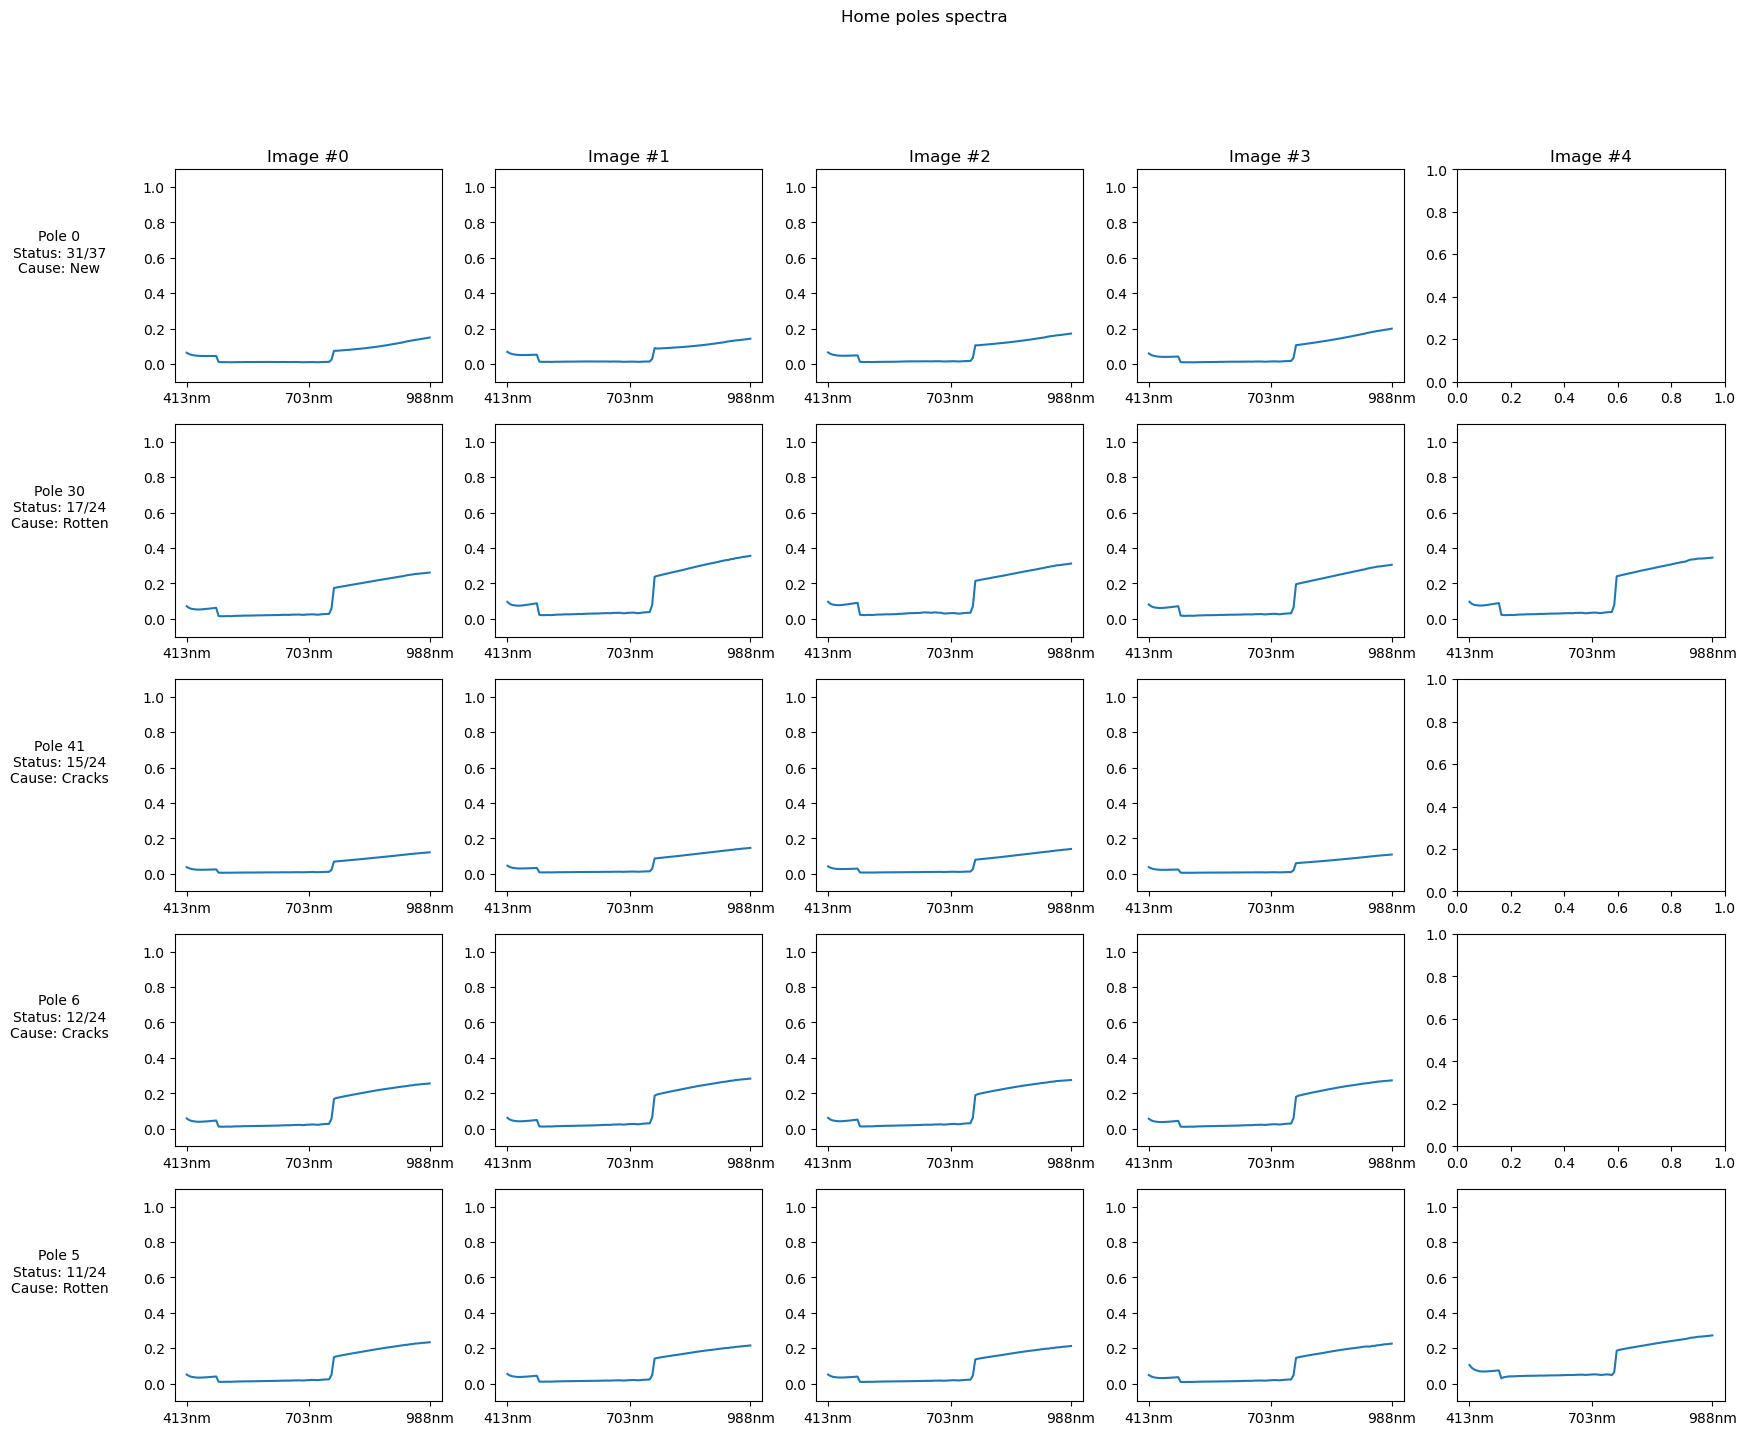

In [67]:
plot_average_spectra_per_pole_and_rotation(get_white_panel(), False)
plot_average_spectra_per_pole_and_rotation(get_white_panel(), True)

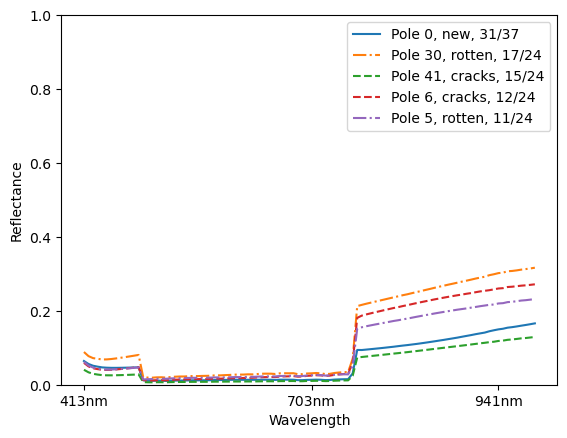

In [70]:
def plot_average_spectra(white_panel):
    pole_ids = [0,30,41,6,5]
    rotation_idxs = [0,1,2,3]
    wavelength_idxs = [0, 50, 91]
    labels = [
        'Pole 0, new, 31/37',
        'Pole 30, rotten, 17/24',
        'Pole 41, cracks, 15/24',
        'Pole 6, cracks, 12/24',
        'Pole 5, rotten, 11/24',
    ]
    lines = ['-', '-.', '--', '--', '-.']
    
    for pole_idx, pole_id in enumerate(pole_ids):
        paths = os.listdir(os.path.join(scans_dir, str(pole_id)))
        paths = [path for path in paths if "float32.hdr" in path]
        paths.sort()
        rotation_spectra = []
        for scan_idx in range(len(paths)):
            img = envi.open(os.path.join(str(pole_id), paths[scan_idx])).load()
            wls = np.asarray(img.metadata['wavelength'], float)
            img = crop_hyperspectral(img)
            spectrum = np.average(img, axis=(0,1))
            white_spectrum = np.average(white_panel, axis=(0,1))
            rotation_spectra.append(spectrum / white_spectrum)
        avg_spectrum = np.average(rotation_spectra, axis=0)
        plt.plot(range(len(avg_spectrum)), avg_spectrum, linestyle=lines[pole_idx], label=labels[pole_idx])
    plt.ylim((0, 1.0))
    plt.xticks(wavelength_idxs, [f'{wls[idx]:.0f}nm' for idx in wavelength_idxs])
    plt.xlabel('Wavelength')
    plt.ylabel('Reflectance')
    plt.legend()
    plt.savefig('home_hyperspectral_results.png')
            
plot_average_spectra(get_white_panel())

Comparing this figure with the figure of the controlled-environment scans, one can see the same patterns appearing:

- Poles 0 and 41 have the lowest reflectance curves, although in this case, pole 41's curve is slightly lower than the new pole's one.
- The differences between the different spectra are small on shorter wavelengths, but these get higher the longer the wavelengths become.
- The poles with highest reflectances are the ones in worst condition (30, 6 and 5).

However, there's a potential problem for applying this technique: even if the same patterns occur, the scale of these patterns is smaller than with the controlled-environment scans, so it is difficult to set thresholds to determine the status of a pole. If the reflectance of a new pole was available for every lighting condition, this could be solved, but this is difficult *a priori*. More thought must be dedicated to solve this problem.

## Hyperspectral variation analysis

As with the other poles, the same transformations can be applied to further analyse these.

In [4]:
def view_hyperspectral_transformed(transform_func, description):
    fig, axes = plt.subplots(5, 5, figsize=(20,16))
    pole_ids = [0,30,41,6,5]
    pole_status = ['31/37', '17/24', '15/24', '12/24', '11/24']
    specific_status = ['New', 'Rotten', 'Cracks', 'Cracks', 'Rotten']

    for pole_idx, pole_id in enumerate(pole_ids):
        paths = os.listdir(os.path.join("C:\\Users\\ext-lugo\\Hyperspectral\\Radiance_home", str(pole_id)))
        paths = [path for path in paths if "float32.hdr" in path]
        paths.sort()
        for scan_idx in range(len(paths)):
            img = envi.open(os.path.join(str(pole_id), paths[scan_idx])).load()
            img = transform_func(img)
            axes[pole_idx, scan_idx].imshow(img)

    fig.suptitle(description)

    [axes[0,i].set_title(f'Image #{i}') for i in range(5)]

    [axes[i,0].set_ylabel(f'Pole {pole}\nStatus: {pole_status[i]}\nCause: {specific_status[i]}', labelpad=60, fontdict={'rotation':0}) for i, pole in enumerate(pole_ids)]
    
    plt.savefig(f'../Figures/Home hyperspectral {description}.png', dpi=1000)

### False RGB

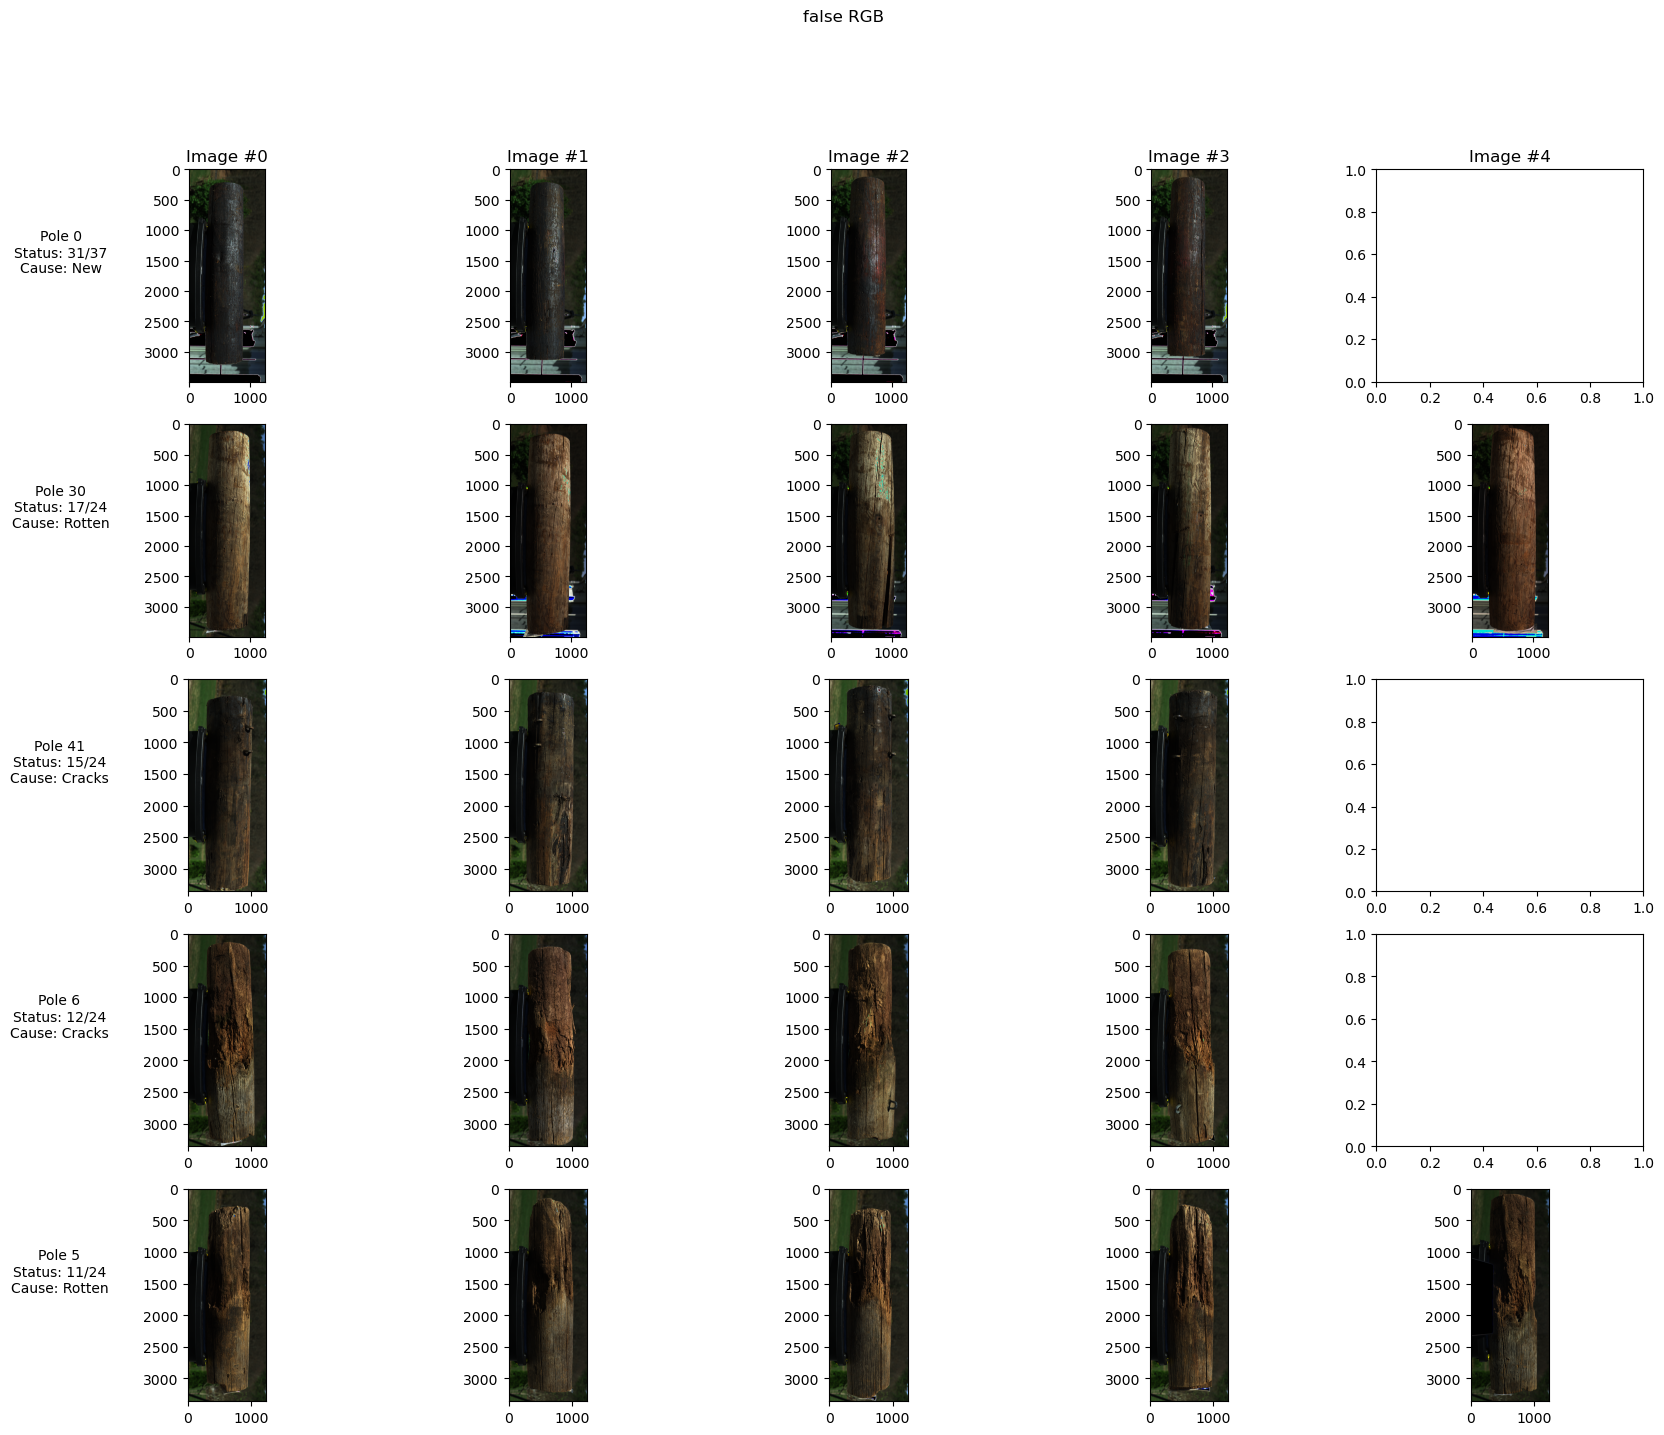

In [73]:
def hyperspectral_to_false_rgb(img):
    img = np.take(img, [39, 24, 8], axis=2)
    orig_shape = img.shape
    img = img.flatten()
    img = np.where(is_outlier(img, thresh=10), 0, img)
    img = np.reshape(img, orig_shape)
    
    img[...,0] = np.interp(img[...,0], (img[...,0].min(), img[...,0].max()), (0, 1))
    img[...,1] = np.interp(img[...,1], (img[...,1].min(), img[...,1].max()), (0, 1))
    img[...,2] = np.interp(img[...,2], (img[...,2].min(), img[...,2].max()), (0, 1))
    
    return img

view_hyperspectral_transformed(hyperspectral_to_false_rgb, 'false RGB')

By looking at these images, it is possible to infer more information about the scans. They were indeed taken outdoors, near an structure that is most likely a house.

### Light scattering corrected

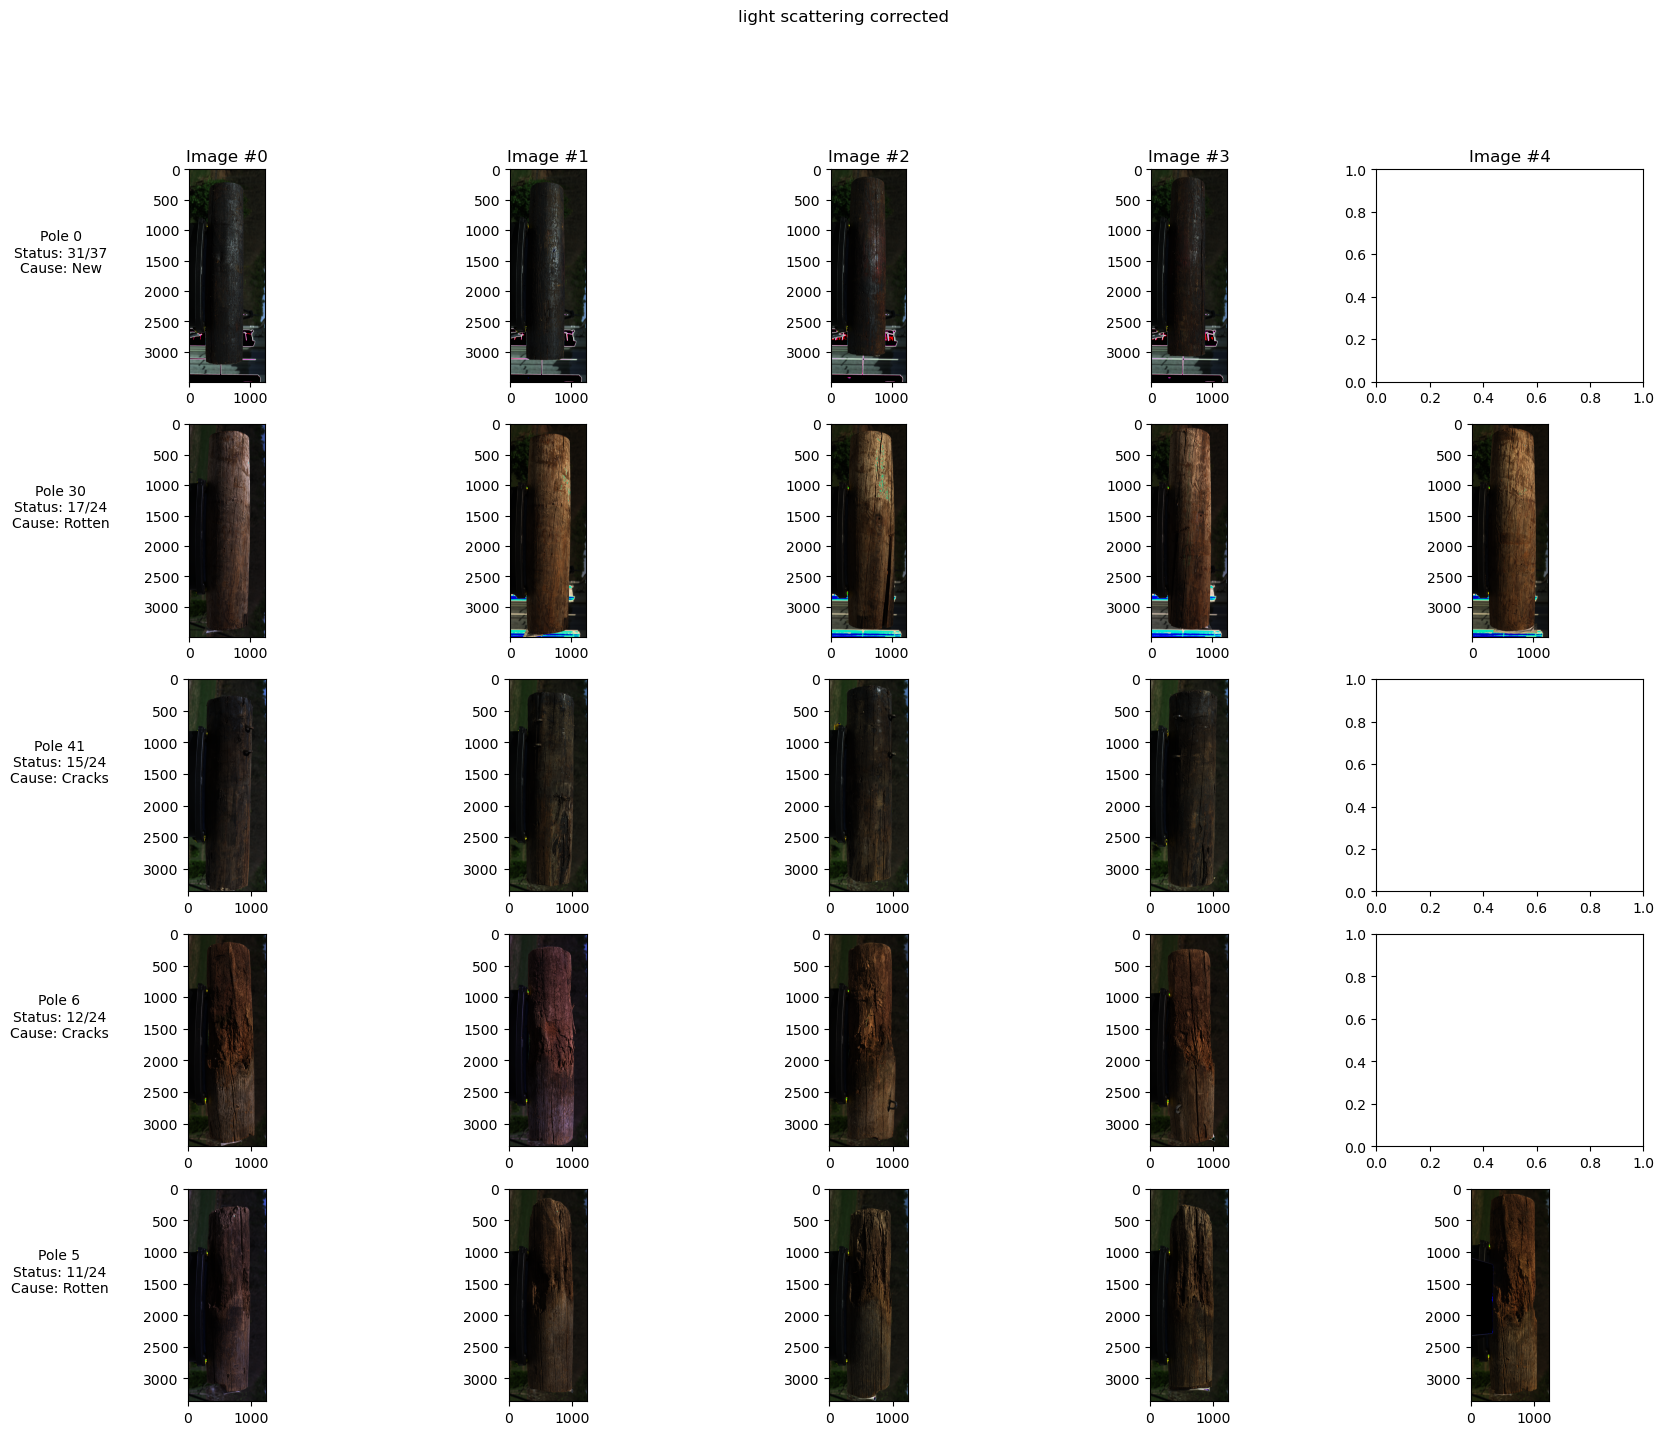

In [5]:
def hyperspectral_to_light_correct(img):
    orig_shape = img.shape
    img = img.flatten()
    img = np.where(is_outlier(img, thresh=10), 0, img)
    img = np.reshape(img, orig_shape)
    img = (img - np.mean(img, axis=(0,1))) / np.std(img, axis=(0,1))
    img = np.take(img, [39, 24, 8], axis=2)
    
    img[...,0] = np.interp(img[...,0], (img[...,0].min(), img[...,0].max()), (0, 1))
    img[...,1] = np.interp(img[...,1], (img[...,1].min(), img[...,1].max()), (0, 1))
    img[...,2] = np.interp(img[...,2], (img[...,2].min(), img[...,2].max()), (0, 1))
    
    return img

view_hyperspectral_transformed(hyperspectral_to_light_correct, 'light scattering corrected')

### Chemical variation

In [13]:
def hyperspectral_to_chemical(img):
    img = img[300:3100, 300:900, :]
    orig_shape = img.shape
    img = img.flatten()
    img = np.where(is_outlier(img, thresh=10), 0, img)
    img = np.reshape(img, orig_shape)
    original_dims = img.shape[:-1]
    img = np.reshape(img, (-1, img.shape[-1]))

    pca = PCA(svd_solver='full')
    reduced_img = pca.fit_transform(img)
    reduced_img = np.reshape(reduced_img, (*original_dims, pca.n_components_))
    
    reduced_img[...,0] = np.interp(reduced_img[...,0], (reduced_img[...,0].min(), reduced_img[...,0].max()), (0, 1))
    reduced_img[...,1] = np.interp(reduced_img[...,1], (reduced_img[...,1].min(), reduced_img[...,1].max()), (0, 1))
    reduced_img[...,2] = np.interp(reduced_img[...,2], (reduced_img[...,2].min(), reduced_img[...,2].max()), (0, 1))
    
    return reduced_img[...,:3], pca.components_[:3,...]

def view_hyperspectral_chemical():
    fig, axes = plt.subplots(5, 10, figsize=(35,12))
    pole_ids = [0,30,41,6,5]
    pole_status = ['31/37', '17/24', '15/24', '12/24', '11/24']
    specific_status = ['New', 'Rotten', 'Cracks', 'Cracks', 'Rotten']

    for pole_idx, pole_id in enumerate(pole_ids):
        paths = os.listdir(os.path.join(scans_dir, str(pole_id)))
        paths = [path for path in paths if "float32.hdr" in path]
        paths.sort()
        for scan_idx in range(len(paths)):
            img = envi.open(os.path.join(str(pole_id), paths[scan_idx])).load()
            wls = np.asarray(img.metadata['wavelength'], float)
            img, components = hyperspectral_to_chemical(img)
            axes[pole_idx, scan_idx*2].imshow(img)
            axes[pole_idx, scan_idx*2 + 1].plot(range(len(components[0])), components[0], color='red', label='PC0')
            axes[pole_idx, scan_idx*2 + 1].plot(range(len(components[1])), components[1], color='green', label='PC1')
            axes[pole_idx, scan_idx*2 + 1].plot(range(len(components[2])), components[2], color='blue', label='PC2')
            axes[pole_idx, scan_idx*2 + 1].set_ylim([-1,1])
            axes[pole_idx, scan_idx*2 + 1].set_xticks(range(0, len(wls), 40), [f'{wls[idx]:.0f}nm' for idx in range(0, len(wls), 40)])

    fig.suptitle('Hyperspectral chemical variation and PCA')

    [axes[0,i * 2].set_title(f'Image #{i}') for i in range(5)]

    [axes[i,0].set_ylabel(f'Pole {pole}\nStatus: {pole_status[i]}\nCause: {specific_status[i]}', labelpad=60, fontdict={'rotation':0}) for i, pole in enumerate(pole_ids)]
    
    plt.savefig(f'../Figures/Home hyperspectral chemical PCA.png', dpi=500)

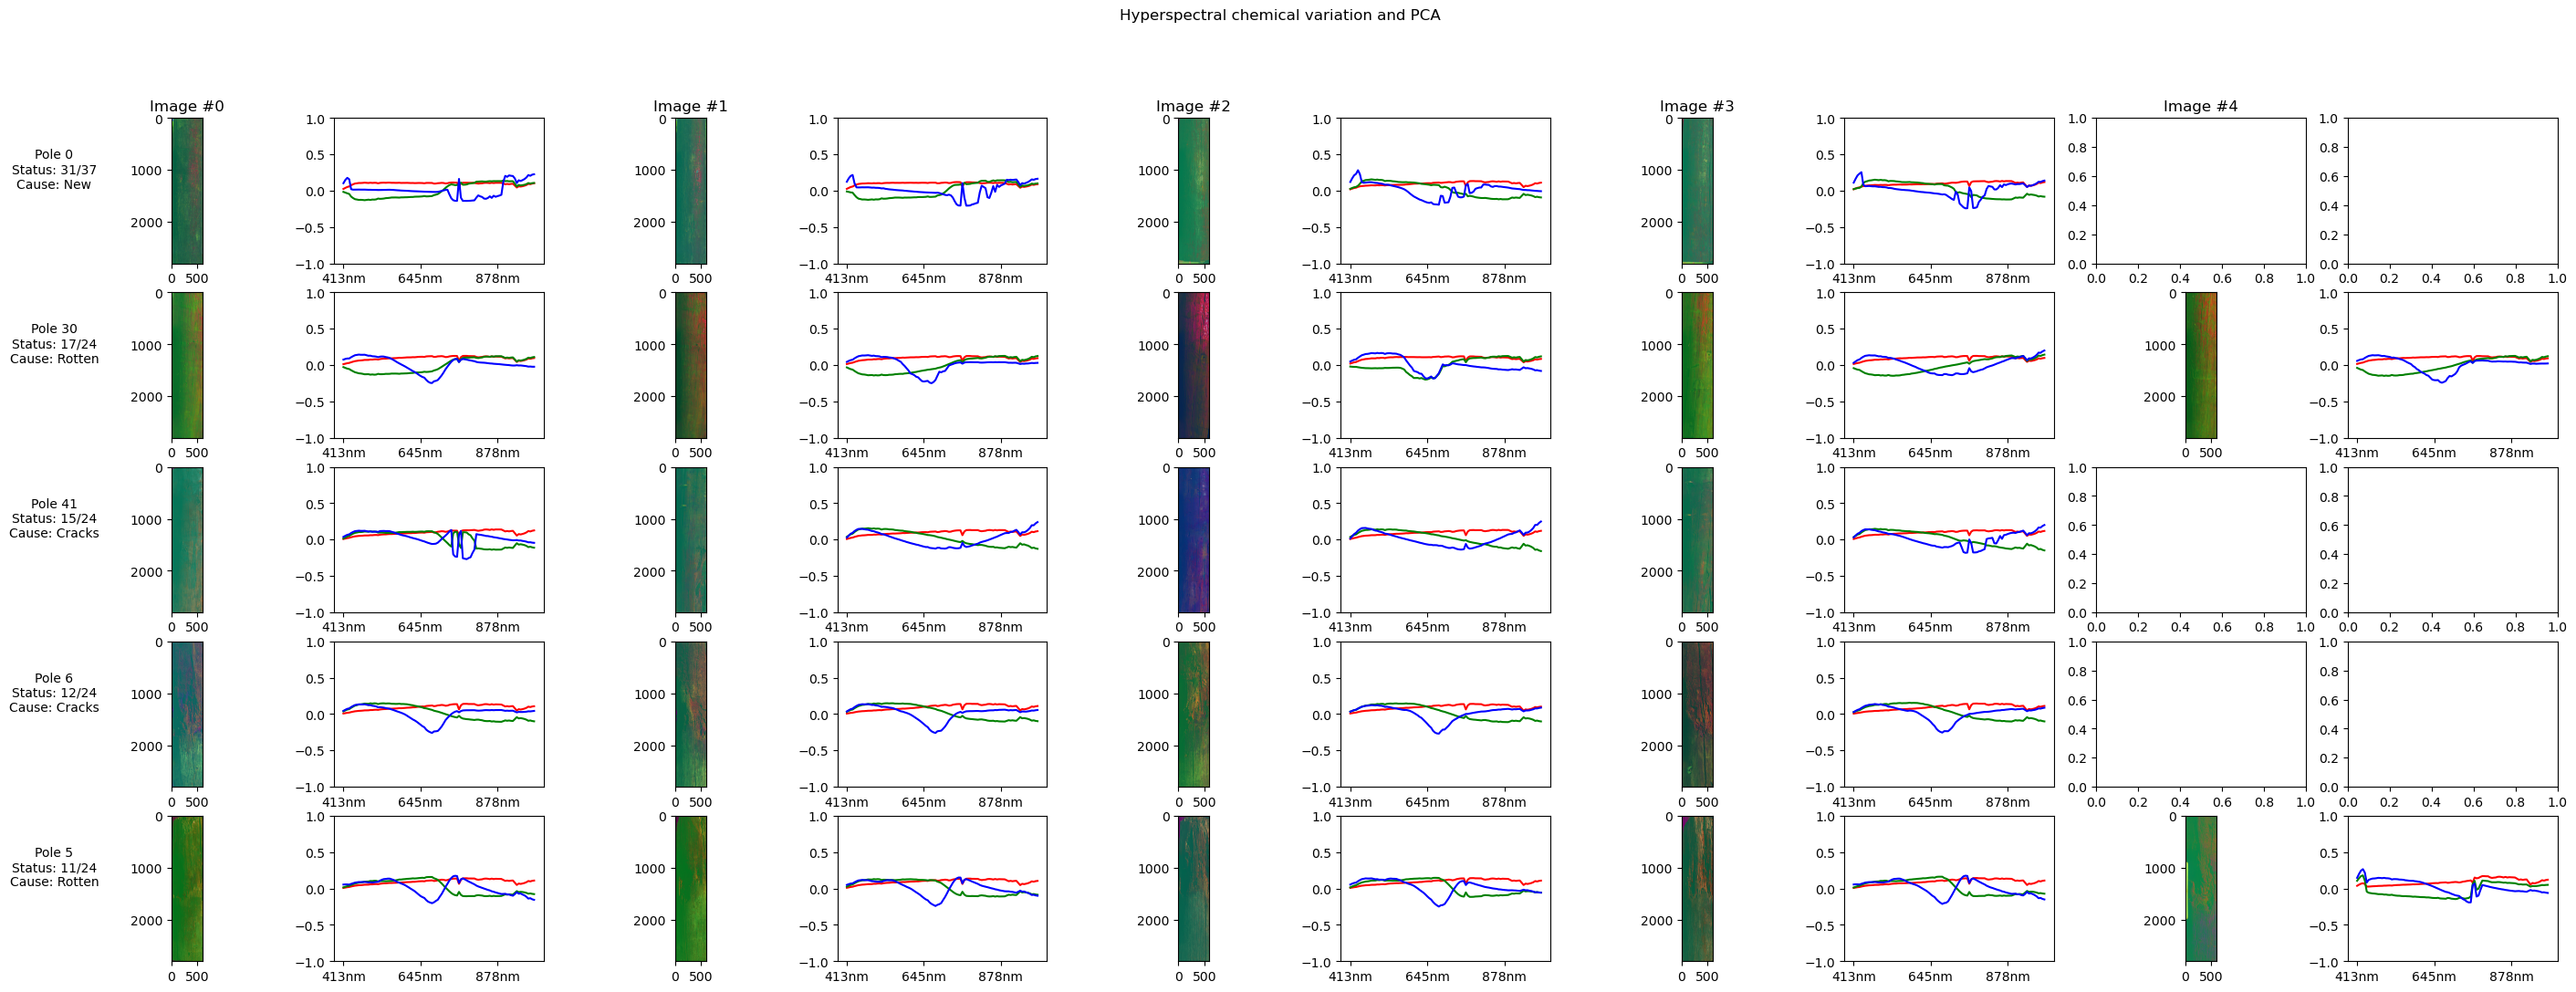

In [14]:
view_hyperspectral_chemical()